In [1]:
pip install pandas yfinance statsmodels matplotlib chardet pmdarima numpy==1.26.4


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Last date in training data: 20250312
Current working directory: /workspaces/llm-portfolio-manager/model_training
Files in directory: ['train_arima_with_yfinance_data.ipynb', 'model_trained']
Number of unique tickers in yfinance data: 503


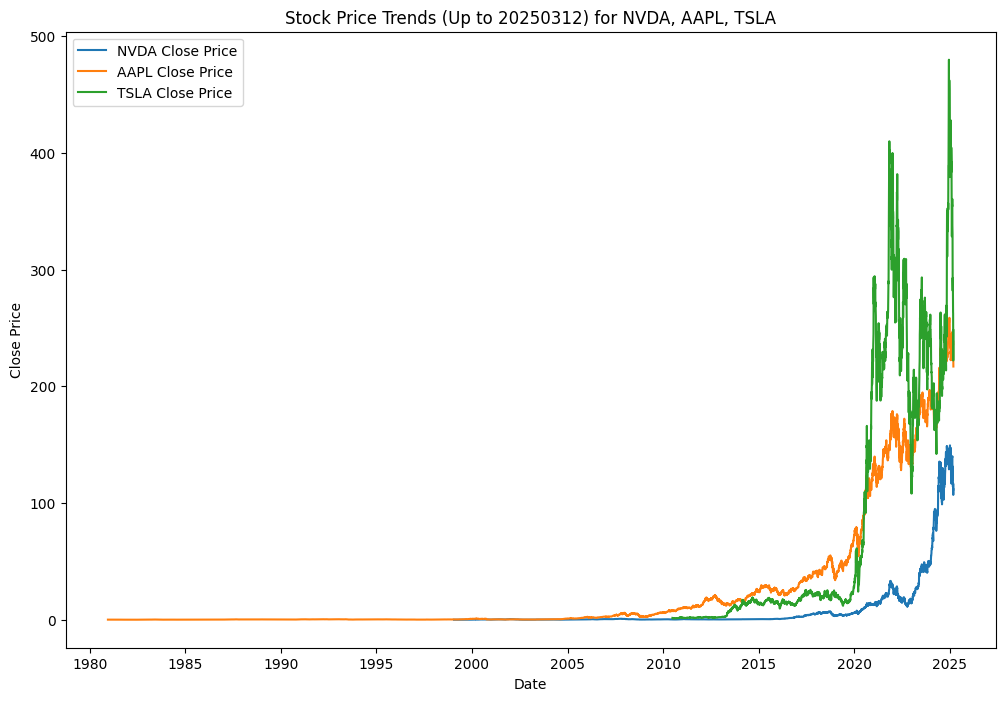

[0/503] Starting ARIMA training at 2025-03-13 07:26:16.857428
[0/503] Last date in training data: 20250312
[0/503] Number of unique tickers in yfinance data: 503
[1/503] Best ARIMA order for MMM: (2, 1, 0)
[1/503] Saved lightweight model for MMM to model_trained/arima/arima_model_MMM_pre_20250312.pkl (875 bytes)
[2/503] Best ARIMA order for MSI: (3, 1, 0)
[2/503] Saved lightweight model for MSI to model_trained/arima/arima_model_MSI_pre_20250312.pkl (893 bytes)
[3/503] Best ARIMA order for MRK: (3, 1, 0)
[3/503] Saved lightweight model for MRK to model_trained/arima/arima_model_MRK_pre_20250312.pkl (893 bytes)
[4/503] Best ARIMA order for KR: (3, 1, 3)
[4/503] Saved lightweight model for KR to model_trained/arima/arima_model_KR_pre_20250312.pkl (947 bytes)
[5/503] Best ARIMA order for JNJ: (1, 1, 0)
[5/503] Saved lightweight model for JNJ to model_trained/arima/arima_model_JNJ_pre_20250312.pkl (857 bytes)
[6/503] Best ARIMA order for IP: (2, 1, 0)
[6/503] Saved lightweight model for IP

In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import yfinance as yf  # Not used for fetching here, but kept for consistency
from statsmodels.tsa.arima.model import ARIMA
try:
    import pmdarima as pm  # For auto_arima
    AUTO_ARIMA_AVAILABLE = True
except ImportError as e:
    print(f"Warning: pmdarima not available: {e}. Falling back to manual ARIMA(1,1,0).")
    AUTO_ARIMA_AVAILABLE = False
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import numpy as np
from datetime import datetime

# Suppress FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

%matplotlib inline

# Cell 2: Load and Prepare Data
# Load the yfinance CSV file
data_path = "../data-too-big/sp500_daily_data_yfinance.csv"
df = pd.read_csv(data_path)

# Ensure date is in datetime format (strip timezone if present)
df['date'] = pd.to_datetime(df['date'].str.replace(r'[-+]\d{2}:\d{2}', '', regex=True))

# Use all data for training
train_df = df.sort_values('date')

# Get the last date in the data for naming the models
last_date = train_df['date'].max()
last_date_str = last_date.strftime('%Y%m%d')  # e.g., '20250312'
print(f"Last date in training data: {last_date_str}")

# Debug current working directory
print(f"Current working directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir()}")

# Get unique tickers from the yfinance data
tickers = train_df['symbol'].unique()
total_tickers = len(tickers)
print(f"Number of unique tickers in yfinance data: {total_tickers}")

# Cell 3: Plot NVDA, AAPL, and TSLA Trends (up to last date)
plot_tickers = ['NVDA', 'AAPL', 'TSLA']
plt.figure(figsize=(12, 8))
for ticker in plot_tickers:
    if ticker in tickers:
        ticker_df = train_df[train_df['symbol'] == ticker][['date', 'close']].set_index('date').dropna()
        if not ticker_df.empty:
            plt.plot(ticker_df['close'], label=f'{ticker} Close Price')
        else:
            print(f"No data found for {ticker}.")
    else:
        print(f"{ticker} not in yfinance data.")

plt.title(f'Stock Price Trends (Up to {last_date_str}) for NVDA, AAPL, TSLA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Cell 4: Train and Save Lightweight ARIMA Models with Logging
output_folder = "model_trained/arima"
os.makedirs(output_folder, exist_ok=True)

# Create log directory and file
log_folder = "../log"
os.makedirs(log_folder, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
log_file = os.path.join(log_folder, f"train_arima_with_yfinance_data_{timestamp}.txt")

# Function to log messages to both console and file
def log_message(index, total, message, file):
    progress = f"{index}/{total}"
    print(f"[{progress}] {message}")
    with open(file, 'a') as f:
        f.write(f"[{progress}] {message}\n")

# Minimum number of observations needed for ARIMA
MIN_OBS = 10

# Open log file and start logging
log_message(0, total_tickers, f"Starting ARIMA training at {datetime.now()}", log_file)
log_message(0, total_tickers, f"Last date in training data: {last_date_str}", log_file)
log_message(0, total_tickers, f"Number of unique tickers in yfinance data: {total_tickers}", log_file)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=Warning, module="statsmodels")
    for index, ticker in enumerate(tickers, start=1):
        try:
            ticker_df = train_df[train_df['symbol'] == ticker][['date', 'close']].set_index('date').dropna()
            ticker_df = ticker_df.asfreq('B', method='ffill')  # Business days, forward fill
            if len(ticker_df) < MIN_OBS:
                log_message(index, total_tickers, f"Skipping {ticker}: insufficient data ({len(ticker_df)} rows)", log_file)
                continue

            # Use auto_arima if available, otherwise fall back to ARIMA(1,1,0)
            if AUTO_ARIMA_AVAILABLE:
                auto_model = pm.auto_arima(
                    ticker_df['close'],
                    start_p=0, start_q=0,
                    max_p=3, max_q=3,
                    d=1,  # Force at least one differencing
                    max_d=2,
                    seasonal=False,  # No seasonality for daily stock data
                    stepwise=True,
                    suppress_warnings=True,
                    trace=False
                )
                p, d, q = auto_model.order
                log_message(index, total_tickers, f"Best ARIMA order for {ticker}: ({p}, {d}, {q})", log_file)
            else:
                p, d, q = 1, 1, 0  # Fallback parameters
                log_message(index, total_tickers, f"Using fallback ARIMA order for {ticker}: (1, 1, 0)", log_file)

            # Train the ARIMA model with the best parameters
            model = ARIMA(ticker_df['close'], order=(p, d, q))
            model_fit = model.fit()

            # Save at least the last 10 observations to ensure enough data for differencing
            history_length = max(10, p + d + 1)  # Ensure enough data for p and d
            last_obs = ticker_df['close'].iloc[-history_length:].values

            lightweight_model = {
                'params': model_fit.params,
                'order': (p, d, q),
                'last_obs': last_obs  # Save more historical data
            }
            model_file = os.path.join(output_folder, f'arima_model_{ticker}_pre_{last_date_str}.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(lightweight_model, f, protocol=pickle.HIGHEST_PROTOCOL)
            file_size = os.path.getsize(model_file)
            log_message(index, total_tickers, f"Saved lightweight model for {ticker} to {model_file} ({file_size} bytes)", log_file)
        except Exception as e:
            log_message(index, total_tickers, f"Failed to train model for {ticker}: {str(e)}", log_file)

log_message(total_tickers, total_tickers, f"All lightweight models saved in '{output_folder}' folder.", log_file)

# Cell 5: Predict Next Stock Price for NVDA, AAPL, and TSLA
predict_tickers = ['NVDA', 'AAPL', 'TSLA']
log_message(total_tickers + 1, total_tickers + len(predict_tickers), "\nPredicting next stock prices for NVDA, AAPL, and TSLA:", log_file)

for index, ticker in enumerate(predict_tickers, start=total_tickers + 2):
    try:
        if ticker not in tickers:
            log_message(index, total_tickers + len(predict_tickers), f"{ticker} not in yfinance data.", log_file)
            continue

        model_file = os.path.join(output_folder, f'arima_model_{ticker}_pre_{last_date_str}.pkl')
        if not os.path.exists(model_file):
            log_message(index, total_tickers + len(predict_tickers), f"No model found for {ticker}.", log_file)
            continue

        with open(model_file, 'rb') as f:
            model_data = pickle.load(f)

        # Extract model components
        params = model_data['params']
        order = model_data['order']
        last_obs = model_data['last_obs']

        # Log model details
        log_message(index, total_tickers + len(predict_tickers), f"\nTicker: {ticker}", log_file)
        log_message(index, total_tickers + len(predict_tickers), f"Order: {order}", log_file)
        log_message(index, total_tickers + len(predict_tickers), f"Last observations: {last_obs}", log_file)
        log_message(index, total_tickers + len(predict_tickers), f"Parameters: {params}", log_file)

        # Reconstruct the ARIMA model with the full series
        model = ARIMA(last_obs, order=order)
        model_fit = model.fit(start_params=params)

        # Forecast the next stock price (1 step ahead)
        forecast = model_fit.forecast(steps=1)
        if isinstance(forecast, np.ndarray):
            predicted_value = forecast[0]
        else:
            predicted_value = forecast.iloc[0]

        # Check for valid prediction
        if np.isnan(predicted_value) or np.isinf(predicted_value):
            log_message(index, total_tickers + len(predict_tickers), f"Prediction for {ticker} resulted in invalid value (NaN or Inf).", log_file)
            continue

        predicted_price = round(predicted_value, 2)
        last_price = round(last_obs[-1], 2)
        log_message(index, total_tickers + len(predict_tickers), f"Last closing price for {ticker}: ${last_price}", log_file)
        log_message(index, total_tickers + len(predict_tickers), f"Predicted next stock price for {ticker}: ${predicted_price}", log_file)

    except Exception as e:
        log_message(index, total_tickers + len(predict_tickers), f"Failed to predict for {ticker}: {str(e)}", log_file)

log_message(total_tickers + len(predict_tickers), total_tickers + len(predict_tickers), f"Completed predictions at {datetime.now()}", log_file)